# STEP 1: Imports and Get Data

In [1]:
from model_components.data_reader import FinancialTimeSeriesDataset
from model_components.transformers import TimeSeriesTransformer
from model_components.fin_trainer import TimeSeriesForecastingTrainer
from model_components.utils import (
    create_optimizer,
    create_scheduler,
    plot_lr_schedule
)
from model_components.synth_data import SyntheticTimeSeriesDataset
  
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import tarfile
import shutil
import wandb
import yaml
from sklearn.preprocessing import MinMaxScaler, StandardScaler
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
%%writefile config.yaml

Name                      : "Nayesha-Gopal"

###### Dataset -----------------------------------------------------------------
data:                    # Currently setup for Colab assuming out setup
  root                 : "/local/hw4_data/hw4p1_data"  # TODO: Set the root path of your data
  train_partition      : "train"  # train
  val_partition        : "val"    # val
  test_partition       : "test"   # test
  subset               : 1.0      # Load a subset of the data (for debugging, testing, etc
  batch_size           : 16      #
  NUM_WORKERS          : 2        # Set to 0 for CPU
  forecast_horizon     : 1

###### Network Specs -------------------------------------------------------------
model: # Decoder-Only Language Model (HW4P1)
  d_model                   : 128
  d_ff                      : 64
  d_freq                    : 3    #how many dimensions to split time into- must be odd because it adds 1?
  num_layers                : 2
  num_heads                 : 12
  dropout                   : 0.2

###### Common Training Parameters ------------------------------------------------
training:
  use_wandb                   : False   # Toggle wandb logging
  wandb_run_id                : "none" # "none" or "run_id"
  resume                      : False  # Resume an existing run (run_id != 'none')
  epochs                      : 10
  gradient_accumulation_steps : 1
  wandb_project               : "IDL_final project PegasusNG" # wandb project to log to

###### Loss ----------------------------------------------------------------------
loss: # Just good ol' MSE
  label_smoothing: 0.0

###### Optimizer -----------------------------------------------------------------
optimizer:
  name: "adamw" # Options: sgd, adam, adamw
  lr: 5.0e-4   # Base learning rate

  # Common parameters
  weight_decay: 0.0001

  # Parameter groups
  param_groups:
    - name: self_attn
      patterns: []  # Will match all parameters containing keywords set their learning rate to 0.0001
      lr: 0.0001    # LR for self_attn
      layer_decay:
        enabled: False
        decay_rate: 0.8

    - name: ffn
      patterns: [] # Will match all parameters containing "ffn" and set their learning rate to 0.0001
      lr: 0.0001   # LR for ffn
      layer_decay:
        enabled: False
        decay_rate: 0.8

  # Layer-wise learning rates
  layer_decay:
    enabled: False
    decay_rate: 0.75

  # SGD specific parameters
  sgd:
    momentum: 0.9
    nesterov: True
    dampening: 0

  # Adam specific parameters
  adam:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

  # AdamW specific parameters
  adamw:
    betas: [0.9, 0.999]
    eps: 1.0e-8
    amsgrad: False

###### Scheduler -----------------------------------------------------------------
scheduler:
  name: "cosine"  # Options: reduce_lr, cosine, cosine_warm

  # ReduceLROnPlateau specific parameters
  reduce_lr:
    mode: "min"  # Options: min, max
    factor: 0.1  # Factor to reduce learning rate by
    patience: 10  # Number of epochs with no improvement after which LR will be reduced
    threshold: 0.0001  # Threshold for measuring the new optimum
    threshold_mode: "rel"  # Options: rel, abs
    cooldown: 0  # Number of epochs to wait before resuming normal operation
    min_lr: 0.0000001  # Minimum learning rate
    eps: 1.0e-8  # Minimal decay applied to lr

  # CosineAnnealingLR specific parameters
  cosine:
    T_max: 15  # Maximum number of iterations
    eta_min: 1.0e-8  # Minimum learning rate
    last_epoch: -1

  # CosineAnnealingWarmRestarts specific parameters
  cosine_warm:
    T_0: 4  # Number of iterations for the first restart
    T_mult: 4  # Factor increasing T_i after each restart
    eta_min: 0.0000001  # Minimum learning rate
    last_epoch: -1

  # Warmup parameters (can be used with any scheduler)
  warmup:
    enabled: True
    type: "exponential"  # Options: linear, exponential
    epochs: 5
    start_factor: 0.1
    end_factor: 1.0

Overwriting config.yaml


In [3]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# # create fake data for testing transformer
# # Create dataset
# train_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='train',
#     noise_std=0.05,
#     num_frequencies=2
# )

# val_dataset = SyntheticTimeSeriesDataset(
#     num_sequences=1000,
#     window_size=30,
#     forecast_horizon=5,
#     split='val',
#     noise_std=0.05,
#     num_frequencies=2
# )

# # Sample visualization will auto-show
# print(train_dataset[0][0].shape)  # Should be [30, 1]
# print(train_dataset[0][1].shape)  # Should be [5, 1]

In [5]:
# CREATE DATASETS
train_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='train',
    val_ratio=0.15,
    fit_scaler=True
)
tgt_scaler = train_dataset.tgt_scaler
cls_scaler = train_dataset.cls_scaler

val_dataset = FinancialTimeSeriesDataset(
    tickers=['AAPL'],
    start_date='2015-01-01',
    end_date='2024-12-31',
    window_size=5,
    forecast_horizon=config['data']['forecast_horizon'],
    target='Close',
    normalize='minmax',
    split='val',
    val_ratio=0.15,
    tgt_scaler=tgt_scaler,
    cls_scaler=cls_scaler
)




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


['Open', 'High', 'Low', 'Volume']
after normalization dataset is                 Open      High       Low    Volume
Date                                              
2015-01-02  0.025063  0.022758  0.020406  0.289462
2015-01-05  0.020931  0.019052  0.017820  0.361694
2015-01-06  0.018597  0.017431  0.016780  0.371548
2015-01-07  0.019477  0.018454  0.019540  0.204077
2015-01-08  0.022184  0.023701  0.022206  0.329616
after normalization dataset is Date
2015-01-02    0.021795
2015-01-05    0.017699
2015-01-06    0.017712
2015-01-07    0.019694
2015-01-08    0.025199
Name: Close, dtype: float64
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Time'], dtype='object')


Processing AAPL (train): 100%|██████████████████| 1066/1066 [00:00<00:00, 15143.53it/s]
[*********************100%***********************]  1 of 1 completed


x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shift

Processing AAPL (val): 100%|██████████████████████| 187/187 [00:00<00:00, 19019.25it/s]

x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shifted is (5, 6)
targets_golden is torch.Size([5, 1])
x is (5, 6)
targets_shift

In [6]:
# DATALOADERS
train_loader    = DataLoader(
    dataset     = train_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

val_loader      = DataLoader(
    dataset     = val_dataset,
    batch_size  = config['data']['batch_size'],
    shuffle     = False,
    num_workers = config['data']['NUM_WORKERS'] if device == 'cuda' else 0,
    pin_memory  = True,
)

# STEP 2: Set Up Model

In [7]:
model_config = config['model']
# update this to add model input and output features
print(train_dataset.input_features, val_dataset.output_features)
model_config.update({
    'input_features': train_dataset.input_features,
    'output_features': val_dataset.output_features,              #hardcoded, TODO NEED TO FIX
    'forecast_horizon':  config['data']['forecast_horizon']
})
model = TimeSeriesTransformer(**model_config).to(device)

# CONFIRM EVERYTHING IS BEING LOADED CORRECTLY
for batch in train_loader:
    inputs, targets_shifted, targets_shifted_targfeat, targets_golden = batch

    print("First input sample (shape: {}):".format(inputs[0].shape))
    print(inputs[0])  # shape: [T, F]

    print("Corresponding target (shape: {}):".format(targets_shifted[0].shape))
    print(targets_shifted[0])  # shape: [forecast_steps]

    print("Inputs:", inputs.shape)
    print("Targets:", targets_shifted.shape)
    break

summary(model, input_data=(targets_shifted.to(device), targets_shifted_targfeat.to(device)))


6 1
First input sample (shape: torch.Size([5, 6])):
tensor([[0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0209, 0.0191, 0.0178, 0.0177, 0.3617, 1.0000],
        [0.0186, 0.0174, 0.0168, 0.0177, 0.3715, 2.0000],
        [0.0195, 0.0185, 0.0195, 0.0197, 0.2041, 3.0000],
        [0.0222, 0.0237, 0.0222, 0.0252, 0.3296, 4.0000]])
Corresponding target (shape: torch.Size([5, 6])):
tensor([[0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0251, 0.0228, 0.0204, 0.0218, 0.2895, 0.0000],
        [0.0209, 0.0191, 0.0178, 0.0177, 0.3617, 1.0000],
        [0.0186, 0.0174, 0.0168, 0.0177, 0.3715, 2.0000],
        [0.0195, 0.0185, 0.0195, 0.0197, 0.2041, 3.0000]])
Inputs: torch.Size([16, 5, 6])
Targets: torch.Size([16, 5, 6])


Layer (type:depth-idx)                        Output Shape              Param #
TimeSeriesTransformer                         [16, 5, 1]                1
├─Sequential: 1-1                             [16, 5, 128]              --
│    └─Linear: 2-1                            [16, 5, 128]              768
│    └─GELU: 2-2                              [16, 5, 128]              --
│    └─Dropout: 2-3                           [16, 5, 128]              --
│    └─Linear: 2-4                            [16, 5, 128]              16,512
│    └─GELU: 2-5                              [16, 5, 128]              --
│    └─Dropout: 2-6                           [16, 5, 128]              --
├─Time2VecTorch: 1-2                          [16, 5, 4]                8
├─TimeSeriesPositionalEncoding: 1-3           [16, 5, 132]              --
├─Dropout: 1-4                                [16, 5, 132]              --
├─Linear: 1-5                                 [16, 5, 128]              256
├─Time2VecTorch:

# STEP 3: Setup WandB and Trainer

In [8]:
wandb.login(key="b78dba2c54228a3e3e32bd91a1a1efca38d69bb9")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /jet/home/gandotra/.netrc
wandb: Currently logged in as: nayeshag (nayeshag-carnegie-mellon-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
# wandb.finish()

In [10]:
trainer = TimeSeriesForecastingTrainer(
    model=model,
    config=config,
    run_name="test-1-fin2",
    config_file="config.yaml",
    scaler=tgt_scaler,
    device=device
)
print("done with init!")

False
done with init!


here!

🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0005
├── Weight Decay: 0.0001
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0001
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.999]
    ├── Epsilon: 1e-08
    └── AMSGrad: False

📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 15 epochs (1005 steps)
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (335 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


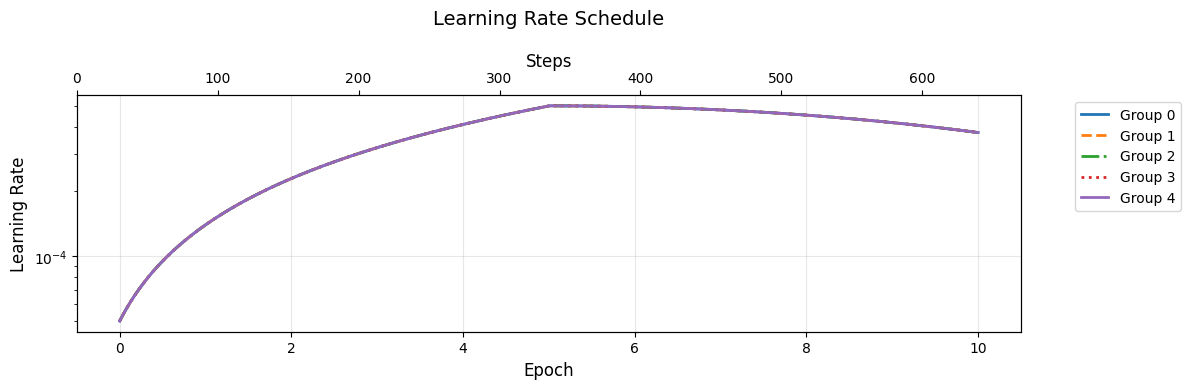

In [11]:
trainer.optimizer = create_optimizer(
    model=model,
    opt_config=config['optimizer']
)

trainer.scheduler = create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=config['training']['epochs'], 
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)

# Initialize WandB
# if trainer.use_wandb:
#     wandb.init(
#         project=trainer.config['training'].get('wandb_project', 'time-series-forecasting'),
#         config=trainer.config,
#         name=trainer.run_name,
#         settings=wandb.Settings(
#         start_method="thread",             # don't spawn multiprocessing process
#         )
#     )


# Step 4: TRAIN!!   

In [12]:
print("here!")
trainer.train(train_loader, val_loader, epochs=50)

here!


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


/jet/home/psamal/hw_envs/idl_hw4/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MeanAbsoluteError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
Training:   9%| | 6/67 [00:00<00:02, 21.54it/s, batch_accuracy=0.00%, loss=0.0064, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 31.06it/s, batch_accuracy=0.00%, loss=0.0069, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 31.06it/s, batch_accuracy=2.50%, loss=0.0061, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 38.25it/s, batch_accuracy=5.00%, loss=0.0062, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 42.38it/s, batch_accuracy=8.75%, loss=0.0044, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 44.54it/s, batch_accuracy=3.75%, loss=0.0100, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 45.63it/s, batch_accuracy=25.00%, loss=0.0037, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:01<00:00, 47.27it/s, batch_accuracy=11.25%, loss=0.0095, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  69%|▋| 46/67 [00:01<00:00, 48.23it/s, batch_accuracy=0.00%, loss=0.0830, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.09it/s, batch_accuracy=0.00%, loss=0.0543, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  85%|▊| 57/67 [00:01<00:00, 48.78it/s, batch_accuracy=38.75%, loss=0.0167, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 49.09it/s, batch_accuracy=15.00%, loss=0.0512, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 42.36it/s, batch_accuracy=74.00%, loss=0.0071, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 0 Metrics:
  TRAIN      | train_loss: 0.0209 | train_mae: nan | train_accuracy: 12.4015


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.1965, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.62it/s, batch_accuracy=0.00%, loss=0.3361, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  16%|▏| 11/67 [00:00<00:01, 40.62it/s, batch_accuracy=0.00%, loss=0.2566, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 46.65it/s, batch_accuracy=0.00%, loss=0.0298, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  31%|▎| 21/67 [00:00<00:00, 46.65it/s, batch_accuracy=2.50%, loss=0.0138, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 47.82it/s, batch_accuracy=5.00%, loss=0.0099, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  48%|▍| 32/67 [00:00<00:00, 47.82it/s, batch_accuracy=7.50%, loss=0.0085, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 49.09it/s, batch_accuracy=0.00%, loss=0.0596, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  63%|▋| 42/67 [00:00<00:00, 49.09it/s, batch_accuracy=0.00%, loss=0.0805, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 48.75it/s, batch_accuracy=0.00%, loss=0.2627, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  79%|▊| 53/67 [00:01<00:00, 48.75it/s, batch_accuracy=0.00%, loss=0.2412, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 49.65it/s, batch_accuracy=0.00%, loss=0.0977, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  94%|▉| 63/67 [00:01<00:00, 49.65it/s, batch_accuracy=1.25%, loss=0.0630, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.97it/s, batch_accuracy=0.00%, loss=0.1578, mae


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 1 Metrics:
  TRAIN      | train_loss: 0.1670 | train_mae: nan | train_accuracy: 1.8011


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=0.00%, loss=0.0433, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   4%| | 3/67 [00:00<00:02, 27.43it/s, batch_accuracy=0.00%, loss=0.1842, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.06it/s, batch_accuracy=0.00%, loss=0.2941, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 40.06it/s, batch_accuracy=0.00%, loss=0.3058, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 45.20it/s, batch_accuracy=0.00%, loss=0.2424, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.44it/s, batch_accuracy=0.00%, loss=0.1025, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  33%|▎| 22/67 [00:00<00:00, 46.44it/s, batch_accuracy=0.00%, loss=0.0595, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 47.59it/s, batch_accuracy=0.00%, loss=0.0475, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.53it/s, batch_accuracy=22.50%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  48%|▍| 32/67 [00:00<00:00, 48.53it/s, batch_accuracy=0.00%, loss=0.0118, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  49%|▍| 33/67 [00:00<00:00, 48.53it/s, batch_accuracy=17.50%, loss=0.0048, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 49.60it/s, batch_accuracy=5.00%, loss=0.0239, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  64%|▋| 43/67 [00:00<00:00, 49.60it/s, batch_accuracy=0.00%, loss=0.0903, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  66%|▋| 44/67 [00:00<00:00, 49.60it/s, batch_accuracy=0.00%, loss=0.1635, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.81it/s, batch_accuracy=0.00%, loss=0.2556, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  81%|▊| 54/67 [00:01<00:00, 50.31it/s, batch_accuracy=0.00%, loss=0.3580, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  82%|▊| 55/67 [00:01<00:00, 50.31it/s, batch_accuracy=0.00%, loss=0.3567, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 50.25it/s, batch_accuracy=1.25%, loss=0.0801, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  97%|▉| 65/67 [00:01<00:00, 50.90it/s, batch_accuracy=0.00%, loss=0.1569, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.75it/s, batch_accuracy=0.00%, loss=0.1956, mae



📈 Epoch 2 Metrics:
  TRAIN      | train_loss: 0.1428 | train_mae: nan | train_accuracy: 2.4390


Training:   1%| | 1/67 [00:00<00:05, 11.17it/s, batch_accuracy=0.00%, loss=0.0738, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   7%| | 5/67 [00:00<00:02, 27.10it/s, batch_accuracy=0.00%, loss=0.2317, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.25it/s, batch_accuracy=0.00%, loss=0.2391, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  18%|▏| 12/67 [00:00<00:01, 41.25it/s, batch_accuracy=0.00%, loss=0.2265, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  24%|▏| 16/67 [00:00<00:01, 45.46it/s, batch_accuracy=0.00%, loss=0.1547, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 47.87it/s, batch_accuracy=0.00%, loss=0.0797, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  34%|▎| 23/67 [00:00<00:00, 47.87it/s, batch_accuracy=0.00%, loss=0.0471, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  40%|▍| 27/67 [00:00<00:00, 48.52it/s, batch_accuracy=0.00%, loss=0.0196, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 49.30it/s, batch_accuracy=0.00%, loss=0.0236, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  51%|▌| 34/67 [00:00<00:00, 49.30it/s, batch_accuracy=8.75%, loss=0.0072, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  57%|▌| 38/67 [00:00<00:00, 49.92it/s, batch_accuracy=21.25%, loss=0.0059, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.92it/s, batch_accuracy=0.00%, loss=0.0322, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  67%|▋| 45/67 [00:00<00:00, 50.07it/s, batch_accuracy=0.00%, loss=0.1286, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 50.52it/s, batch_accuracy=0.00%, loss=0.1826, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.52it/s, batch_accuracy=0.00%, loss=0.2370, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  84%|▊| 56/67 [00:01<00:00, 50.38it/s, batch_accuracy=0.00%, loss=0.3106, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  90%|▉| 60/67 [00:01<00:00, 50.38it/s, batch_accuracy=0.00%, loss=0.2086, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.84it/s, batch_accuracy=0.00%, loss=0.1437, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 48.26it/s, batch_accuracy=0.00%, loss=0.2472, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 3 Metrics:
  TRAIN      | train_loss: 0.1318 | train_mae: nan | train_accuracy: 2.5891


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   4%| | 3/67 [00:00<00:02, 26.57it/s, batch_accuracy=0.00%, loss=0.1084, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.77it/s, batch_accuracy=0.00%, loss=0.2018, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  15%|▏| 10/67 [00:00<00:01, 40.77it/s, batch_accuracy=0.00%, loss=0.2031, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 45.80it/s, batch_accuracy=0.00%, loss=0.1596, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.80it/s, batch_accuracy=0.00%, loss=0.0940, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 48.26it/s, batch_accuracy=0.00%, loss=0.0644, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 48.26it/s, batch_accuracy=0.00%, loss=0.0410, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 49.08it/s, batch_accuracy=2.50%, loss=0.0164, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  49%|▍| 33/67 [00:00<00:00, 49.63it/s, batch_accuracy=0.00%, loss=0.0198, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.63it/s, batch_accuracy=12.50%, loss=0.0047, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 49.65it/s, batch_accuracy=18.75%, loss=0.0058, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 49.73it/s, batch_accuracy=0.00%, loss=0.0583, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  72%|▋| 48/67 [00:01<00:00, 49.76it/s, batch_accuracy=0.00%, loss=0.1971, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.76it/s, batch_accuracy=0.00%, loss=0.2640, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  81%|▊| 54/67 [00:01<00:00, 50.00it/s, batch_accuracy=0.00%, loss=0.2314, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  85%|▊| 57/67 [00:01<00:00, 50.00it/s, batch_accuracy=0.00%, loss=0.2673, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 50.47it/s, batch_accuracy=0.00%, loss=0.1269, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.47it/s, batch_accuracy=0.00%, loss=0.1562, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.93it/s, batch_accuracy=0.00%, loss=0.2728, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 4 Metrics:
  TRAIN      | train_loss: 0.1201 | train_mae: nan | train_accuracy: 2.2702


Training:   4%| | 3/67 [00:00<00:02, 26.25it/s, batch_accuracy=0.00%, loss=0.0416, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   4%| | 3/67 [00:00<00:02, 26.25it/s, batch_accuracy=0.00%, loss=0.0570, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.66it/s, batch_accuracy=0.00%, loss=0.1691, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  18%|▏| 12/67 [00:00<00:01, 40.66it/s, batch_accuracy=0.00%, loss=0.1831, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  19%|▏| 13/67 [00:00<00:01, 40.66it/s, batch_accuracy=0.00%, loss=0.1646, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 47.51it/s, batch_accuracy=0.00%, loss=0.0869, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  34%|▎| 23/67 [00:00<00:00, 47.51it/s, batch_accuracy=0.00%, loss=0.0578, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 47.51it/s, batch_accuracy=0.00%, loss=0.0571, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 49.31it/s, batch_accuracy=0.00%, loss=0.0369, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  51%|▌| 34/67 [00:00<00:00, 49.31it/s, batch_accuracy=1.25%, loss=0.0166, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  52%|▌| 35/67 [00:00<00:00, 49.31it/s, batch_accuracy=2.50%, loss=0.0087, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 50.12it/s, batch_accuracy=0.00%, loss=0.0184, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  67%|▋| 45/67 [00:00<00:00, 50.12it/s, batch_accuracy=0.00%, loss=0.1030, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  69%|▋| 46/67 [00:00<00:00, 50.12it/s, batch_accuracy=0.00%, loss=0.1288, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.26it/s, batch_accuracy=0.00%, loss=0.2220, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  84%|▊| 56/67 [00:01<00:00, 50.71it/s, batch_accuracy=0.00%, loss=0.3042, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  85%|▊| 57/67 [00:01<00:00, 50.71it/s, batch_accuracy=0.00%, loss=0.2560, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.42it/s, batch_accuracy=0.00%, loss=0.1434, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 47.95it/s, batch_accuracy=0.00%, loss=0.2491, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 5 Metrics:
  TRAIN      | train_loss: 0.1130 | train_mae: nan | train_accuracy: 2.4203


Training:   4%| | 3/67 [00:00<00:02, 25.85it/s, batch_accuracy=0.00%, loss=0.0317, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.47it/s, batch_accuracy=0.00%, loss=0.1611, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  19%|▏| 13/67 [00:00<00:01, 40.47it/s, batch_accuracy=0.00%, loss=0.1622, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 47.46it/s, batch_accuracy=0.00%, loss=0.0980, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  36%|▎| 24/67 [00:00<00:00, 47.46it/s, batch_accuracy=0.00%, loss=0.0591, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.59it/s, batch_accuracy=0.00%, loss=0.0386, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  52%|▌| 35/67 [00:00<00:00, 49.55it/s, batch_accuracy=0.00%, loss=0.0131, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.52it/s, batch_accuracy=1.25%, loss=0.0163, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  69%|▋| 46/67 [00:00<00:00, 50.02it/s, batch_accuracy=0.00%, loss=0.1248, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.13it/s, batch_accuracy=0.00%, loss=0.2195, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  85%|▊| 57/67 [00:01<00:00, 50.17it/s, batch_accuracy=0.00%, loss=0.2548, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.69it/s, batch_accuracy=0.00%, loss=0.1466, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 47.89it/s, batch_accuracy=0.00%, loss=0.2595, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 6 Metrics:
  TRAIN      | train_loss: 0.1115 | train_mae: nan | train_accuracy: 2.3827


Training:   4%| | 3/67 [00:00<00:02, 28.14it/s, batch_accuracy=1.25%, loss=0.0491, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 42.25it/s, batch_accuracy=0.00%, loss=0.1272, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 46.64it/s, batch_accuracy=0.00%, loss=0.1576, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.76it/s, batch_accuracy=0.00%, loss=0.0912, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 49.22it/s, batch_accuracy=0.00%, loss=0.0618, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 49.66it/s, batch_accuracy=0.00%, loss=0.0416, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.66it/s, batch_accuracy=10.00%, loss=0.0094, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 50.07it/s, batch_accuracy=2.50%, loss=0.0133, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:00<00:00, 50.23it/s, batch_accuracy=0.00%, loss=0.1821, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.62it/s, batch_accuracy=0.00%, loss=0.2058, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.55it/s, batch_accuracy=0.00%, loss=0.1341, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.94it/s, batch_accuracy=0.00%, loss=0.1435, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 48.40it/s, batch_accuracy=0.00%, loss=0.2456, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 7 Metrics:
  TRAIN      | train_loss: 0.1074 | train_mae: nan | train_accuracy: 2.4015


Training:   4%| | 3/67 [00:00<00:02, 26.43it/s, batch_accuracy=2.50%, loss=0.0136, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.05it/s, batch_accuracy=0.00%, loss=0.1408, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 45.57it/s, batch_accuracy=0.00%, loss=0.1629, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 47.52it/s, batch_accuracy=0.00%, loss=0.0907, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 47.52it/s, batch_accuracy=0.00%, loss=0.0614, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 49.15it/s, batch_accuracy=0.00%, loss=0.0451, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.15it/s, batch_accuracy=2.50%, loss=0.0108, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.92it/s, batch_accuracy=16.25%, loss=0.0116, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 50.11it/s, batch_accuracy=0.00%, loss=0.1707, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.01it/s, batch_accuracy=0.00%, loss=0.1919, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.46it/s, batch_accuracy=0.00%, loss=0.1358, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.49it/s, batch_accuracy=0.00%, loss=0.1477, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.95it/s, batch_accuracy=0.00%, loss=0.2220, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 8 Metrics:
  TRAIN      | train_loss: 0.1030 | train_mae: nan | train_accuracy: 2.7767


Training:   4%| | 3/67 [00:00<00:02, 25.93it/s, batch_accuracy=1.25%, loss=0.0278, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.19it/s, batch_accuracy=0.00%, loss=0.1201, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  21%|▏| 14/67 [00:00<00:01, 44.96it/s, batch_accuracy=0.00%, loss=0.1419, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.53it/s, batch_accuracy=0.00%, loss=0.0927, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  37%|▎| 25/67 [00:00<00:00, 48.11it/s, batch_accuracy=0.00%, loss=0.0645, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 49.34it/s, batch_accuracy=0.00%, loss=0.0527, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  52%|▌| 35/67 [00:00<00:00, 49.34it/s, batch_accuracy=2.50%, loss=0.0135, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 49.84it/s, batch_accuracy=2.50%, loss=0.0145, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  69%|▋| 46/67 [00:00<00:00, 49.84it/s, batch_accuracy=0.00%, loss=0.1188, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.31it/s, batch_accuracy=0.00%, loss=0.1965, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  85%|▊| 57/67 [00:01<00:00, 50.30it/s, batch_accuracy=0.00%, loss=0.2356, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.53it/s, batch_accuracy=0.00%, loss=0.1086, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 47.83it/s, batch_accuracy=0.00%, loss=0.2056, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 9 Metrics:
  TRAIN      | train_loss: 0.0965 | train_mae: nan | train_accuracy: 2.2702


Training:   4%| | 3/67 [00:00<00:02, 26.78it/s, batch_accuracy=0.00%, loss=0.0176, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.15it/s, batch_accuracy=0.00%, loss=0.0917, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 44.82it/s, batch_accuracy=0.00%, loss=0.1453, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.05it/s, batch_accuracy=0.00%, loss=0.1061, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 48.70it/s, batch_accuracy=0.00%, loss=0.0648, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 49.05it/s, batch_accuracy=0.00%, loss=0.0413, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  55%|▌| 37/67 [00:00<00:00, 49.76it/s, batch_accuracy=6.25%, loss=0.0161, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 50.06it/s, batch_accuracy=6.25%, loss=0.0172, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 50.06it/s, batch_accuracy=0.00%, loss=0.1721, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.05it/s, batch_accuracy=0.00%, loss=0.1791, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.48it/s, batch_accuracy=0.00%, loss=0.0983, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.52it/s, batch_accuracy=0.00%, loss=0.1089, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.90it/s, batch_accuracy=0.00%, loss=0.1516, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 10 Metrics:
  TRAIN      | train_loss: 0.0926 | train_mae: nan | train_accuracy: 2.6829


Training:   4%| | 3/67 [00:00<00:02, 26.03it/s, batch_accuracy=1.25%, loss=0.0189, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.01it/s, batch_accuracy=0.00%, loss=0.0579, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  21%|▏| 14/67 [00:00<00:01, 44.65it/s, batch_accuracy=0.00%, loss=0.1046, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.33it/s, batch_accuracy=0.00%, loss=0.1073, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  37%|▎| 25/67 [00:00<00:00, 48.18it/s, batch_accuracy=0.00%, loss=0.0709, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.76it/s, batch_accuracy=0.00%, loss=0.0506, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  54%|▌| 36/67 [00:00<00:00, 49.57it/s, batch_accuracy=6.25%, loss=0.0183, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.67it/s, batch_accuracy=1.25%, loss=0.0203, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  70%|▋| 47/67 [00:00<00:00, 50.35it/s, batch_accuracy=0.00%, loss=0.1262, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.29it/s, batch_accuracy=0.00%, loss=0.1758, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  85%|▊| 57/67 [00:01<00:00, 50.29it/s, batch_accuracy=0.00%, loss=0.1739, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  97%|▉| 65/67 [00:01<00:00, 50.84it/s, batch_accuracy=5.00%, loss=0.0480, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 47.80it/s, batch_accuracy=0.00%, loss=0.1344, mae


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 11 Metrics:
  TRAIN      | train_loss: 0.0820 | train_mae: nan | train_accuracy: 3.0769


Training:   4%| | 3/67 [00:00<00:02, 27.42it/s, batch_accuracy=1.25%, loss=0.0152, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.43it/s, batch_accuracy=2.50%, loss=0.0537, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 46.03it/s, batch_accuracy=0.00%, loss=0.1432, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.28it/s, batch_accuracy=0.00%, loss=0.0958, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 48.99it/s, batch_accuracy=0.00%, loss=0.0736, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 49.29it/s, batch_accuracy=0.00%, loss=0.0487, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  55%|▌| 37/67 [00:00<00:00, 49.92it/s, batch_accuracy=12.50%, loss=0.0100, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 50.17it/s, batch_accuracy=15.00%, loss=0.0145, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:00<00:00, 50.17it/s, batch_accuracy=0.00%, loss=0.1519, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.22it/s, batch_accuracy=0.00%, loss=0.1952, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.57it/s, batch_accuracy=3.75%, loss=0.0708, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.26it/s, batch_accuracy=35.00%, loss=0.0223, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 48.04it/s, batch_accuracy=12.00%, loss=0.0938, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 12 Metrics:
  TRAIN      | train_loss: 0.0734 | train_mae: nan | train_accuracy: 4.8593


Training:   4%| | 3/67 [00:00<00:02, 27.42it/s, batch_accuracy=2.50%, loss=0.0145, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.15it/s, batch_accuracy=2.50%, loss=0.0588, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 45.37it/s, batch_accuracy=1.25%, loss=0.0715, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.58it/s, batch_accuracy=1.25%, loss=0.0767, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 48.20it/s, batch_accuracy=1.25%, loss=0.0558, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 49.18it/s, batch_accuracy=0.00%, loss=0.0545, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  55%|▌| 37/67 [00:00<00:00, 49.73it/s, batch_accuracy=15.00%, loss=0.0169, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.79it/s, batch_accuracy=16.25%, loss=0.0179, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  72%|▋| 48/67 [00:00<00:00, 50.37it/s, batch_accuracy=0.00%, loss=0.1179, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  81%|▊| 54/67 [00:01<00:00, 50.28it/s, batch_accuracy=2.50%, loss=0.1040, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.28it/s, batch_accuracy=25.00%, loss=0.0535, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.70it/s, batch_accuracy=31.25%, loss=0.0401, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 48.04it/s, batch_accuracy=46.00%, loss=0.0282, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 13 Metrics:
  TRAIN      | train_loss: 0.0604 | train_mae: nan | train_accuracy: 7.7298


Training:   4%| | 3/67 [00:00<00:02, 26.61it/s, batch_accuracy=0.00%, loss=0.0123, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.23it/s, batch_accuracy=5.00%, loss=0.0307, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 45.73it/s, batch_accuracy=3.75%, loss=0.0581, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 47.65it/s, batch_accuracy=1.25%, loss=0.0365, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 47.65it/s, batch_accuracy=5.00%, loss=0.0368, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 49.09it/s, batch_accuracy=2.50%, loss=0.0528, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.53it/s, batch_accuracy=12.50%, loss=0.0181, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.67it/s, batch_accuracy=16.25%, loss=0.0200, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:00<00:00, 50.25it/s, batch_accuracy=6.25%, loss=0.1117, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.35it/s, batch_accuracy=12.50%, loss=0.0862, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.65it/s, batch_accuracy=32.50%, loss=0.0523, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.66it/s, batch_accuracy=41.25%, loss=0.0263, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 48.15it/s, batch_accuracy=44.00%, loss=0.0521, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 14 Metrics:
  TRAIN      | train_loss: 0.0493 | train_mae: nan | train_accuracy: 10.0188


Training:   4%| | 3/67 [00:00<00:02, 27.06it/s, batch_accuracy=3.75%, loss=0.0058, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 41.71it/s, batch_accuracy=0.00%, loss=0.0321, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 45.06it/s, batch_accuracy=1.25%, loss=0.0374, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.54it/s, batch_accuracy=6.25%, loss=0.0323, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 48.30it/s, batch_accuracy=8.75%, loss=0.0177, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.83it/s, batch_accuracy=1.25%, loss=0.0398, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  55%|▌| 37/67 [00:00<00:00, 49.50it/s, batch_accuracy=6.25%, loss=0.0277, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 49.75it/s, batch_accuracy=16.25%, loss=0.0153, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 49.75it/s, batch_accuracy=8.75%, loss=0.1164, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 50.20it/s, batch_accuracy=10.00%, loss=0.0890, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.08it/s, batch_accuracy=42.50%, loss=0.0298, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.29it/s, batch_accuracy=32.50%, loss=0.0291, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.87it/s, batch_accuracy=30.00%, loss=0.0774, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 15 Metrics:
  TRAIN      | train_loss: 0.0412 | train_mae: nan | train_accuracy: 10.9006


Training:   4%| | 3/67 [00:00<00:02, 25.37it/s, batch_accuracy=6.25%, loss=0.0019, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  12%| | 8/67 [00:00<00:01, 37.74it/s, batch_accuracy=0.00%, loss=0.0245, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  19%|▏| 13/67 [00:00<00:01, 42.76it/s, batch_accuracy=1.25%, loss=0.0708, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  27%|▎| 18/67 [00:00<00:01, 43.82it/s, batch_accuracy=2.50%, loss=0.0581, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  34%|▎| 23/67 [00:00<00:00, 45.56it/s, batch_accuracy=13.75%, loss=0.0290, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  42%|▍| 28/67 [00:00<00:00, 46.11it/s, batch_accuracy=10.00%, loss=0.0150, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  49%|▍| 33/67 [00:00<00:00, 46.81it/s, batch_accuracy=2.50%, loss=0.0296, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  57%|▌| 38/67 [00:00<00:00, 46.91it/s, batch_accuracy=26.25%, loss=0.0052, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 46.71it/s, batch_accuracy=25.00%, loss=0.0127, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  73%|▋| 49/67 [00:01<00:00, 47.52it/s, batch_accuracy=30.00%, loss=0.0554, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 47.57it/s, batch_accuracy=18.75%, loss=0.0925, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  88%|▉| 59/67 [00:01<00:00, 48.14it/s, batch_accuracy=38.75%, loss=0.0517, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 48.39it/s, batch_accuracy=30.00%, loss=0.0245, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 45.50it/s, batch_accuracy=48.00%, loss=0.0272, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 16 Metrics:
  TRAIN      | train_loss: 0.0361 | train_mae: nan | train_accuracy: 15.1407


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=1.25%, loss=0.0068, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  12%| | 8/67 [00:00<00:01, 37.41it/s, batch_accuracy=0.00%, loss=0.0119, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  18%|▏| 12/67 [00:00<00:01, 42.21it/s, batch_accuracy=1.25%, loss=0.0215, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.32it/s, batch_accuracy=2.50%, loss=0.0256, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  31%|▎| 21/67 [00:00<00:01, 45.32it/s, batch_accuracy=2.50%, loss=0.0410, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 47.52it/s, batch_accuracy=13.75%, loss=0.0176, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  46%|▍| 31/67 [00:00<00:00, 47.52it/s, batch_accuracy=5.00%, loss=0.0263, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  58%|▌| 39/67 [00:00<00:00, 48.31it/s, batch_accuracy=25.00%, loss=0.0107, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  61%|▌| 41/67 [00:00<00:00, 48.31it/s, batch_accuracy=18.75%, loss=0.0078, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 49.13it/s, batch_accuracy=36.25%, loss=0.0409, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  76%|▊| 51/67 [00:01<00:00, 49.13it/s, batch_accuracy=33.75%, loss=0.0623, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  90%|▉| 60/67 [00:01<00:00, 49.27it/s, batch_accuracy=35.00%, loss=0.0382, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  93%|▉| 62/67 [00:01<00:00, 49.27it/s, batch_accuracy=23.75%, loss=0.0244, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.53it/s, batch_accuracy=40.00%, loss=0.0269, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 17 Metrics:
  TRAIN      | train_loss: 0.0285 | train_mae: nan | train_accuracy: 15.1970


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=5.00%, loss=0.0016, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.33it/s, batch_accuracy=0.00%, loss=0.0113, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  16%|▏| 11/67 [00:00<00:01, 40.33it/s, batch_accuracy=0.00%, loss=0.0234, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.15it/s, batch_accuracy=7.50%, loss=0.0295, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  31%|▎| 21/67 [00:00<00:00, 47.15it/s, batch_accuracy=3.75%, loss=0.0551, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.46it/s, batch_accuracy=10.00%, loss=0.0274, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  48%|▍| 32/67 [00:00<00:00, 48.46it/s, batch_accuracy=5.00%, loss=0.0235, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.84it/s, batch_accuracy=27.50%, loss=0.0082, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  63%|▋| 42/67 [00:00<00:00, 48.84it/s, batch_accuracy=18.75%, loss=0.0112, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.02it/s, batch_accuracy=37.50%, loss=0.0255, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  78%|▊| 52/67 [00:01<00:00, 49.02it/s, batch_accuracy=46.25%, loss=0.0254, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.18it/s, batch_accuracy=43.75%, loss=0.0167, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  93%|▉| 62/67 [00:01<00:00, 49.18it/s, batch_accuracy=35.00%, loss=0.0189, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.97it/s, batch_accuracy=58.00%, loss=0.0135, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 18 Metrics:
  TRAIN      | train_loss: 0.0251 | train_mae: nan | train_accuracy: 17.7111


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=3.75%, loss=0.0014, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.44it/s, batch_accuracy=2.50%, loss=0.0049, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  15%|▏| 10/67 [00:00<00:01, 38.44it/s, batch_accuracy=0.00%, loss=0.0113, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.85it/s, batch_accuracy=16.25%, loss=0.0210, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  30%|▎| 20/67 [00:00<00:01, 45.85it/s, batch_accuracy=7.50%, loss=0.0350, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 47.16it/s, batch_accuracy=12.50%, loss=0.0091, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  60%|▌| 40/67 [00:00<00:00, 48.37it/s, batch_accuracy=15.00%, loss=0.0091, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 49.08it/s, batch_accuracy=30.00%, loss=0.0431, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  90%|▉| 60/67 [00:01<00:00, 49.24it/s, batch_accuracy=33.75%, loss=0.0246, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 46.88it/s, batch_accuracy=48.00%, loss=0.0200, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 19 Metrics:
  TRAIN      | train_loss: 0.0233 | train_mae: nan | train_accuracy: 18.7242


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.53it/s, batch_accuracy=0.00%, loss=0.0074, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  15%|▏| 10/67 [00:00<00:01, 40.53it/s, batch_accuracy=0.00%, loss=0.0071, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:00, 47.24it/s, batch_accuracy=5.00%, loss=0.0260, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  30%|▎| 20/67 [00:00<00:00, 47.24it/s, batch_accuracy=8.75%, loss=0.0502, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.96it/s, batch_accuracy=16.25%, loss=0.0069, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  46%|▍| 31/67 [00:00<00:00, 48.96it/s, batch_accuracy=7.50%, loss=0.0079, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.22it/s, batch_accuracy=22.50%, loss=0.0061, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  63%|▋| 42/67 [00:00<00:00, 49.22it/s, batch_accuracy=22.50%, loss=0.0113, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.37it/s, batch_accuracy=45.00%, loss=0.0308, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  78%|▊| 52/67 [00:01<00:00, 49.37it/s, batch_accuracy=42.50%, loss=0.0285, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.36it/s, batch_accuracy=36.25%, loss=0.0148, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  94%|▉| 63/67 [00:01<00:00, 50.08it/s, batch_accuracy=30.00%, loss=0.0254, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.29it/s, batch_accuracy=56.00%, loss=0.0153, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 20 Metrics:
  TRAIN      | train_loss: 0.0192 | train_mae: nan | train_accuracy: 20.9006


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=1.25%, loss=0.0059, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.49it/s, batch_accuracy=0.00%, loss=0.0039, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  15%|▏| 10/67 [00:00<00:01, 38.49it/s, batch_accuracy=0.00%, loss=0.0068, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 38.49it/s, batch_accuracy=0.00%, loss=0.0082, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.51it/s, batch_accuracy=11.25%, loss=0.0174, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  30%|▎| 20/67 [00:00<00:01, 45.51it/s, batch_accuracy=13.75%, loss=0.0224, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:01, 45.51it/s, batch_accuracy=8.75%, loss=0.0209, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 47.57it/s, batch_accuracy=8.75%, loss=0.0233, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  45%|▍| 30/67 [00:00<00:00, 47.57it/s, batch_accuracy=17.50%, loss=0.0094, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 47.57it/s, batch_accuracy=12.50%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  58%|▌| 39/67 [00:00<00:00, 48.74it/s, batch_accuracy=33.75%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  60%|▌| 40/67 [00:00<00:00, 48.74it/s, batch_accuracy=30.00%, loss=0.0063, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 48.74it/s, batch_accuracy=27.50%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  73%|▋| 49/67 [00:01<00:00, 49.69it/s, batch_accuracy=32.50%, loss=0.0321, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 49.69it/s, batch_accuracy=45.00%, loss=0.0188, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.69it/s, batch_accuracy=40.00%, loss=0.0392, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  90%|▉| 60/67 [00:01<00:00, 49.40it/s, batch_accuracy=61.25%, loss=0.0099, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  90%|▉| 60/67 [00:01<00:00, 49.40it/s, batch_accuracy=56.25%, loss=0.0112, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.40it/s, batch_accuracy=22.50%, loss=0.0233, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.75it/s, batch_accuracy=46.00%, loss=0.0176, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 21 Metrics:
  TRAIN      | train_loss: 0.0156 | train_mae: nan | train_accuracy: 20.2064


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.34it/s, batch_accuracy=2.50%, loss=0.0030, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  15%|▏| 10/67 [00:00<00:01, 39.34it/s, batch_accuracy=1.25%, loss=0.0043, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.61it/s, batch_accuracy=15.00%, loss=0.0107, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  45%|▍| 30/67 [00:00<00:00, 48.50it/s, batch_accuracy=10.00%, loss=0.0169, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  61%|▌| 41/67 [00:00<00:00, 49.52it/s, batch_accuracy=25.00%, loss=0.0040, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  78%|▊| 52/67 [00:01<00:00, 49.80it/s, batch_accuracy=41.25%, loss=0.0226, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  94%|▉| 63/67 [00:01<00:00, 49.76it/s, batch_accuracy=33.75%, loss=0.0184, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 47.32it/s, batch_accuracy=58.00%, loss=0.0146, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 22 Metrics:
  TRAIN      | train_loss: 0.0111 | train_mae: nan | train_accuracy: 22.3077


Training:   4%| | 3/67 [00:00<00:02, 25.32it/s, batch_accuracy=0.00%, loss=0.0052, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.59it/s, batch_accuracy=0.00%, loss=0.0025, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  18%|▏| 12/67 [00:00<00:01, 39.59it/s, batch_accuracy=2.50%, loss=0.0026, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 46.17it/s, batch_accuracy=16.25%, loss=0.0024, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  34%|▎| 23/67 [00:00<00:00, 46.17it/s, batch_accuracy=7.50%, loss=0.0059, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 47.74it/s, batch_accuracy=10.00%, loss=0.0121, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  51%|▌| 34/67 [00:00<00:00, 48.72it/s, batch_accuracy=10.00%, loss=0.0098, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 48.58it/s, batch_accuracy=32.50%, loss=0.0056, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  66%|▋| 44/67 [00:00<00:00, 49.20it/s, batch_accuracy=18.75%, loss=0.0254, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.53it/s, batch_accuracy=45.00%, loss=0.0132, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  82%|▊| 55/67 [00:01<00:00, 49.59it/s, batch_accuracy=42.50%, loss=0.0180, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.65it/s, batch_accuracy=38.75%, loss=0.0128, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  97%|▉| 65/67 [00:01<00:00, 50.24it/s, batch_accuracy=71.25%, loss=0.0071, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.16it/s, batch_accuracy=62.00%, loss=0.0135, ma



📈 Epoch 23 Metrics:
  TRAIN      | train_loss: 0.0088 | train_mae: nan | train_accuracy: 23.0019


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=2.50%, loss=0.0023, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   7%| | 5/67 [00:00<00:02, 26.70it/s, batch_accuracy=7.50%, loss=0.0013, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.00it/s, batch_accuracy=2.50%, loss=0.0026, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 39.00it/s, batch_accuracy=2.50%, loss=0.0026, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 44.53it/s, batch_accuracy=12.50%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.27it/s, batch_accuracy=13.75%, loss=0.0023, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  33%|▎| 22/67 [00:00<00:00, 46.27it/s, batch_accuracy=10.00%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 46.99it/s, batch_accuracy=22.50%, loss=0.0062, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.61it/s, batch_accuracy=8.75%, loss=0.0143, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 48.61it/s, batch_accuracy=8.75%, loss=0.0118, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 48.38it/s, batch_accuracy=18.75%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  58%|▌| 39/67 [00:00<00:00, 48.38it/s, batch_accuracy=33.75%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.02it/s, batch_accuracy=30.00%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  69%|▋| 46/67 [00:00<00:00, 49.21it/s, batch_accuracy=31.25%, loss=0.0216, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  73%|▋| 49/67 [00:01<00:00, 49.21it/s, batch_accuracy=43.75%, loss=0.0202, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.25it/s, batch_accuracy=36.25%, loss=0.0179, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  85%|▊| 57/67 [00:01<00:00, 49.49it/s, batch_accuracy=63.75%, loss=0.0122, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  88%|▉| 59/67 [00:01<00:00, 49.49it/s, batch_accuracy=61.25%, loss=0.0092, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 49.75it/s, batch_accuracy=35.00%, loss=0.0180, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.00it/s, batch_accuracy=58.00%, loss=0.0164, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 24 Metrics:
  TRAIN      | train_loss: 0.0091 | train_mae: nan | train_accuracy: 23.3396



Training:   1%| | 1/67 [00:00<00:06, 10.09it/s, batch_accuracy=12.50%, loss=0.0009, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.83it/s, batch_accuracy=0.00%, loss=0.0020, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  18%|▏| 12/67 [00:00<00:01, 39.83it/s, batch_accuracy=2.50%, loss=0.0023, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.78it/s, batch_accuracy=13.75%, loss=0.0016, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 46.40it/s, batch_accuracy=11.25%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 47.09it/s, batch_accuracy=18.75%, loss=0.0078, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  51%|▌| 34/67 [00:00<00:00, 47.75it/s, batch_accuracy=10.00%, loss=0.0084, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.79it/s, batch_accuracy=45.00%, loss=0.0040, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  64%|▋| 43/67 [00:00<00:00, 48.79it/s, batch_accuracy=27.50%, loss=0.0098, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.45it/s, batch_accuracy=43.75%, loss=0.0142, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  81%|▊| 54/67 [00:01<00:00, 49.45it/s, batch_accuracy=30.00%, loss=0.0253, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  90%|▉| 60/67 [00:01<00:00, 49.24it/s, batch_accuracy=51.25%, loss=0.0153, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  96%|▉| 64/67 [00:01<00:00, 49.59it/s, batch_accuracy=55.00%, loss=0.0092, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.69it/s, batch_accuracy=54.00%, loss=0.0154, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 25 Metrics:
  TRAIN      | train_loss: 0.0072 | train_mae: nan | train_accuracy: 26.3039


Training:   4%| | 3/67 [00:00<00:02, 25.52it/s, batch_accuracy=10.00%, loss=0.0018, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.69it/s, batch_accuracy=1.25%, loss=0.0018, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 44.49it/s, batch_accuracy=1.25%, loss=0.0022, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.94it/s, batch_accuracy=15.00%, loss=0.0017, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 47.64it/s, batch_accuracy=23.75%, loss=0.0025, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.13it/s, batch_accuracy=17.50%, loss=0.0065, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  51%|▌| 34/67 [00:00<00:00, 48.13it/s, batch_accuracy=10.00%, loss=0.0136, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 48.93it/s, batch_accuracy=35.00%, loss=0.0053, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  69%|▋| 46/67 [00:00<00:00, 48.88it/s, batch_accuracy=52.50%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.05it/s, batch_accuracy=40.00%, loss=0.0094, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  84%|▊| 56/67 [00:01<00:00, 49.33it/s, batch_accuracy=46.25%, loss=0.0158, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.34it/s, batch_accuracy=53.75%, loss=0.0097, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 49.97it/s, batch_accuracy=56.00%, loss=0.0133, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.89it/s, batch_accuracy=56.00%, loss=0.0133, ma



📈 Epoch 26 Metrics:
  TRAIN      | train_loss: 0.0066 | train_mae: nan | train_accuracy: 26.3227


Training:   7%| | 5/67 [00:00<00:02, 25.54it/s, batch_accuracy=6.25%, loss=0.0007, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.29it/s, batch_accuracy=2.50%, loss=0.0016, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 43.70it/s, batch_accuracy=5.00%, loss=0.0014, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 45.97it/s, batch_accuracy=23.75%, loss=0.0015, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 47.26it/s, batch_accuracy=20.00%, loss=0.0032, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.97it/s, batch_accuracy=17.50%, loss=0.0050, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.03it/s, batch_accuracy=12.50%, loss=0.0086, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 49.03it/s, batch_accuracy=20.00%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 49.97it/s, batch_accuracy=46.25%, loss=0.0086, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 49.97it/s, batch_accuracy=66.25%, loss=0.0040, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.23it/s, batch_accuracy=58.75%, loss=0.0078, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  91%|▉| 61/67 [00:01<00:00, 50.23it/s, batch_accuracy=41.25%, loss=0.0125, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.20it/s, batch_accuracy=52.00%, loss=0.0112, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 27 Metrics:
  TRAIN      | train_loss: 0.0054 | train_mae: nan | train_accuracy: 27.5047


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=8.75%, loss=0.0009, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.04it/s, batch_accuracy=6.25%, loss=0.0012, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  16%|▏| 11/67 [00:00<00:01, 39.04it/s, batch_accuracy=1.25%, loss=0.0014, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.59it/s, batch_accuracy=3.75%, loss=0.0028, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  31%|▎| 21/67 [00:00<00:00, 46.59it/s, batch_accuracy=12.50%, loss=0.0025, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.21it/s, batch_accuracy=12.50%, loss=0.0048, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  48%|▍| 32/67 [00:00<00:00, 48.21it/s, batch_accuracy=10.00%, loss=0.0110, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.89it/s, batch_accuracy=31.25%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  63%|▋| 42/67 [00:00<00:00, 48.89it/s, batch_accuracy=40.00%, loss=0.0050, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 49.30it/s, batch_accuracy=62.50%, loss=0.0064, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  78%|▊| 52/67 [00:01<00:00, 49.30it/s, batch_accuracy=58.75%, loss=0.0106, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 49.98it/s, batch_accuracy=43.75%, loss=0.0150, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  94%|▉| 63/67 [00:01<00:00, 49.98it/s, batch_accuracy=42.50%, loss=0.0149, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.11it/s, batch_accuracy=52.00%, loss=0.0182, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 28 Metrics:
  TRAIN      | train_loss: 0.0056 | train_mae: nan | train_accuracy: 28.3865


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   3%| | 2/67 [00:00<00:03, 19.16it/s, batch_accuracy=15.00%, loss=0.0009, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.84it/s, batch_accuracy=2.50%, loss=0.0013, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  15%|▏| 10/67 [00:00<00:01, 38.84it/s, batch_accuracy=2.50%, loss=0.0014, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  19%|▏| 13/67 [00:00<00:01, 43.59it/s, batch_accuracy=3.75%, loss=0.0009, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.83it/s, batch_accuracy=7.50%, loss=0.0032, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:01, 45.83it/s, batch_accuracy=10.00%, loss=0.0027, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 47.45it/s, batch_accuracy=15.00%, loss=0.0031, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 48.08it/s, batch_accuracy=23.75%, loss=0.0020, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  46%|▍| 31/67 [00:00<00:00, 48.08it/s, batch_accuracy=7.50%, loss=0.0067, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  49%|▍| 33/67 [00:00<00:00, 48.08it/s, batch_accuracy=10.00%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 49.42it/s, batch_accuracy=42.50%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  63%|▋| 42/67 [00:00<00:00, 49.42it/s, batch_accuracy=40.00%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  66%|▋| 44/67 [00:00<00:00, 49.42it/s, batch_accuracy=61.25%, loss=0.0061, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.95it/s, batch_accuracy=68.75%, loss=0.0047, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 49.95it/s, batch_accuracy=65.00%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  82%|▊| 55/67 [00:01<00:00, 49.95it/s, batch_accuracy=35.00%, loss=0.0212, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 49.48it/s, batch_accuracy=36.25%, loss=0.0135, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 49.48it/s, batch_accuracy=57.50%, loss=0.0091, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  99%|▉| 66/67 [00:01<00:00, 49.48it/s, batch_accuracy=36.00%, loss=0.0146, ma

train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.00it/s, batch_accuracy=36.00%, loss=0.0146, ma



📈 Epoch 29 Metrics:
  TRAIN      | train_loss: 0.0049 | train_mae: nan | train_accuracy: 29.0056


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   4%| | 3/67 [00:00<00:02, 25.69it/s, batch_accuracy=13.75%, loss=0.0005, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   6%| | 4/67 [00:00<00:02, 25.69it/s, batch_accuracy=18.75%, loss=0.0005, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.14it/s, batch_accuracy=1.25%, loss=0.0013, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  15%|▏| 10/67 [00:00<00:01, 38.14it/s, batch_accuracy=0.00%, loss=0.0021, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 44.10it/s, batch_accuracy=15.00%, loss=0.0006, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 44.10it/s, batch_accuracy=16.25%, loss=0.0007, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.83it/s, batch_accuracy=5.00%, loss=0.0023, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 45.83it/s, batch_accuracy=8.75%, loss=0.0026, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  34%|▎| 23/67 [00:00<00:00, 45.83it/s, batch_accuracy=15.00%, loss=0.0026, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 47.47it/s, batch_accuracy=21.25%, loss=0.0015, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 47.65it/s, batch_accuracy=20.00%, loss=0.0027, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 47.65it/s, batch_accuracy=23.75%, loss=0.0031, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  49%|▍| 33/67 [00:00<00:00, 47.65it/s, batch_accuracy=30.00%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  52%|▌| 35/67 [00:00<00:00, 48.26it/s, batch_accuracy=17.50%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.43it/s, batch_accuracy=33.75%, loss=0.0046, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.43it/s, batch_accuracy=41.25%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 48.43it/s, batch_accuracy=47.50%, loss=0.0053, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  69%|▋| 46/67 [00:00<00:00, 49.04it/s, batch_accuracy=50.00%, loss=0.0065, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  73%|▋| 49/67 [00:01<00:00, 49.04it/s, batch_accuracy=62.50%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.00it/s, batch_accuracy=56.25%, loss=0.0064, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  81%|▊| 54/67 [00:01<00:00, 49.00it/s, batch_accuracy=40.00%, loss=0.0181, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  84%|▊| 56/67 [00:01<00:00, 48.81it/s, batch_accuracy=62.50%, loss=0.0095, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  88%|▉| 59/67 [00:01<00:00, 48.81it/s, batch_accuracy=65.00%, loss=0.0069, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  90%|▉| 60/67 [00:01<00:00, 48.81it/s, batch_accuracy=66.25%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 49.34it/s, batch_accuracy=70.00%, loss=0.0059, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  97%|▉| 65/67 [00:01<00:00, 49.34it/s, batch_accuracy=65.00%, loss=0.0084, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 46.62it/s, batch_accuracy=42.00%, loss=0.0181, ma



📈 Epoch 30 Metrics:
  TRAIN      | train_loss: 0.0046 | train_mae: nan | train_accuracy: 30.6567


Training:   4%| | 3/67 [00:00<00:02, 26.32it/s, batch_accuracy=17.50%, loss=0.0006, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   7%| | 5/67 [00:00<00:02, 26.32it/s, batch_accuracy=1.25%, loss=0.0011, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 40.89it/s, batch_accuracy=3.75%, loss=0.0016, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  21%|▏| 14/67 [00:00<00:01, 44.14it/s, batch_accuracy=2.50%, loss=0.0006, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 44.14it/s, batch_accuracy=17.50%, loss=0.0007, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.28it/s, batch_accuracy=8.75%, loss=0.0029, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 47.39it/s, batch_accuracy=16.25%, loss=0.0021, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  37%|▎| 25/67 [00:00<00:00, 47.39it/s, batch_accuracy=22.50%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 48.23it/s, batch_accuracy=26.25%, loss=0.0039, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  51%|▌| 34/67 [00:00<00:00, 48.38it/s, batch_accuracy=22.50%, loss=0.0069, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  52%|▌| 35/67 [00:00<00:00, 48.38it/s, batch_accuracy=15.00%, loss=0.0098, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 49.35it/s, batch_accuracy=33.75%, loss=0.0049, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 49.35it/s, batch_accuracy=47.50%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  67%|▋| 45/67 [00:00<00:00, 49.01it/s, batch_accuracy=58.75%, loss=0.0045, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 49.29it/s, batch_accuracy=63.75%, loss=0.0052, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 49.29it/s, batch_accuracy=73.75%, loss=0.0053, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  82%|▊| 55/67 [00:01<00:00, 49.44it/s, batch_accuracy=50.00%, loss=0.0113, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 50.04it/s, batch_accuracy=68.75%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 50.04it/s, batch_accuracy=72.50%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 50.55it/s, batch_accuracy=42.00%, loss=0.0168, ma

train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.25it/s, batch_accuracy=42.00%, loss=0.0168, ma



📈 Epoch 31 Metrics:
  TRAIN      | train_loss: 0.0045 | train_mae: nan | train_accuracy: 31.2008


Training:   3%| | 2/67 [00:00<00:03, 19.34it/s, batch_accuracy=6.25%, loss=0.0007, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   6%| | 4/67 [00:00<00:03, 19.34it/s, batch_accuracy=17.50%, loss=0.0008, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.98it/s, batch_accuracy=2.50%, loss=0.0021, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  19%|▏| 13/67 [00:00<00:01, 43.49it/s, batch_accuracy=8.75%, loss=0.0009, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 43.49it/s, batch_accuracy=12.50%, loss=0.0007, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 46.78it/s, batch_accuracy=6.25%, loss=0.0036, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  36%|▎| 24/67 [00:00<00:00, 47.85it/s, batch_accuracy=13.75%, loss=0.0025, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 47.85it/s, batch_accuracy=28.75%, loss=0.0019, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.96it/s, batch_accuracy=1.25%, loss=0.0047, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.44it/s, batch_accuracy=8.75%, loss=0.0049, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  55%|▌| 37/67 [00:00<00:00, 49.44it/s, batch_accuracy=28.75%, loss=0.0033, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 49.98it/s, batch_accuracy=42.50%, loss=0.0041, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:00<00:00, 49.73it/s, batch_accuracy=66.25%, loss=0.0035, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  72%|▋| 48/67 [00:01<00:00, 49.73it/s, batch_accuracy=70.00%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  79%|▊| 53/67 [00:01<00:00, 49.56it/s, batch_accuracy=70.00%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 50.06it/s, batch_accuracy=68.75%, loss=0.0051, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  88%|▉| 59/67 [00:01<00:00, 50.06it/s, batch_accuracy=80.00%, loss=0.0045, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  96%|▉| 64/67 [00:01<00:00, 49.62it/s, batch_accuracy=66.25%, loss=0.0056, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.28it/s, batch_accuracy=58.00%, loss=0.0100, ma


train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 32 Metrics:
  TRAIN      | train_loss: 0.0041 | train_mae: nan | train_accuracy: 32.2514


Training:   4%| | 3/67 [00:00<00:02, 26.10it/s, batch_accuracy=16.25%, loss=0.0007, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 39.16it/s, batch_accuracy=3.75%, loss=0.0018, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  19%|▏| 13/67 [00:00<00:01, 43.81it/s, batch_accuracy=11.25%, loss=0.0007, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.68it/s, batch_accuracy=7.50%, loss=0.0021, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  36%|▎| 24/67 [00:00<00:00, 47.33it/s, batch_accuracy=17.50%, loss=0.0022, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.10it/s, batch_accuracy=18.75%, loss=0.0016, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  49%|▍| 33/67 [00:00<00:00, 48.10it/s, batch_accuracy=21.25%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 48.92it/s, batch_accuracy=25.00%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  66%|▋| 44/67 [00:00<00:00, 48.92it/s, batch_accuracy=47.50%, loss=0.0061, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.42it/s, batch_accuracy=67.50%, loss=0.0047, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  82%|▊| 55/67 [00:01<00:00, 49.42it/s, batch_accuracy=51.25%, loss=0.0122, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 49.99it/s, batch_accuracy=40.00%, loss=0.0132, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  97%|▉| 65/67 [00:01<00:00, 49.99it/s, batch_accuracy=63.75%, loss=0.0076, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.17it/s, batch_accuracy=32.00%, loss=0.0194, ma



📈 Epoch 33 Metrics:
  TRAIN      | train_loss: 0.0040 | train_mae: nan | train_accuracy: 32.3640


Training:   1%| | 1/67 [00:00<00:06, 10.64it/s, batch_accuracy=13.75%, loss=0.0007, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   7%| | 5/67 [00:00<00:02, 25.91it/s, batch_accuracy=3.75%, loss=0.0014, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 38.92it/s, batch_accuracy=5.00%, loss=0.0018, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 38.92it/s, batch_accuracy=0.00%, loss=0.0021, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 43.50it/s, batch_accuracy=16.25%, loss=0.0007, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 46.51it/s, batch_accuracy=12.50%, loss=0.0026, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:00, 46.51it/s, batch_accuracy=12.50%, loss=0.0019, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 47.17it/s, batch_accuracy=21.25%, loss=0.0018, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.25it/s, batch_accuracy=25.00%, loss=0.0027, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 48.25it/s, batch_accuracy=10.00%, loss=0.0041, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 49.02it/s, batch_accuracy=21.25%, loss=0.0036, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  58%|▌| 39/67 [00:00<00:00, 49.02it/s, batch_accuracy=38.75%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  64%|▋| 43/67 [00:00<00:00, 49.07it/s, batch_accuracy=48.75%, loss=0.0051, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 49.50it/s, batch_accuracy=75.00%, loss=0.0036, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 49.50it/s, batch_accuracy=71.25%, loss=0.0028, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  81%|▊| 54/67 [00:01<00:00, 49.33it/s, batch_accuracy=56.25%, loss=0.0111, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 49.79it/s, batch_accuracy=61.25%, loss=0.0061, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 49.79it/s, batch_accuracy=66.25%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  97%|▉| 65/67 [00:01<00:00, 49.79it/s, batch_accuracy=73.75%, loss=0.0061, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.13it/s, batch_accuracy=40.00%, loss=0.0170, ma



📈 Epoch 34 Metrics:
  TRAIN      | train_loss: 0.0037 | train_mae: nan | train_accuracy: 32.9644


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=6.25%, loss=0.0010, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   6%| | 4/67 [00:00<00:03, 19.60it/s, batch_accuracy=6.25%, loss=0.0007, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 37.04it/s, batch_accuracy=0.00%, loss=0.0028, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  15%|▏| 10/67 [00:00<00:01, 37.04it/s, batch_accuracy=0.00%, loss=0.0029, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  22%|▏| 15/67 [00:00<00:01, 43.62it/s, batch_accuracy=11.25%, loss=0.0005, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.94it/s, batch_accuracy=10.00%, loss=0.0022, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  30%|▎| 20/67 [00:00<00:01, 45.94it/s, batch_accuracy=6.25%, loss=0.0033, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  39%|▍| 26/67 [00:00<00:00, 47.70it/s, batch_accuracy=33.75%, loss=0.0012, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 48.20it/s, batch_accuracy=30.00%, loss=0.0012, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 48.20it/s, batch_accuracy=6.25%, loss=0.0049, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  54%|▌| 36/67 [00:00<00:00, 48.68it/s, batch_accuracy=16.25%, loss=0.0046, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 49.00it/s, batch_accuracy=35.00%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  61%|▌| 41/67 [00:00<00:00, 49.00it/s, batch_accuracy=30.00%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  70%|▋| 47/67 [00:01<00:00, 49.58it/s, batch_accuracy=66.25%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  76%|▊| 51/67 [00:01<00:00, 49.28it/s, batch_accuracy=78.75%, loss=0.0036, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 49.28it/s, batch_accuracy=71.25%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  85%|▊| 57/67 [00:01<00:00, 49.80it/s, batch_accuracy=76.25%, loss=0.0056, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 50.21it/s, batch_accuracy=37.50%, loss=0.0158, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 50.21it/s, batch_accuracy=52.50%, loss=0.0090, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 47.17it/s, batch_accuracy=30.00%, loss=0.0186, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 35 Metrics:
  TRAIN      | train_loss: 0.0043 | train_mae: nan | train_accuracy: 31.3696


Training:   1%| | 1/67 [00:00<00:06, 10.12it/s, batch_accuracy=8.75%, loss=0.0008, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   4%| | 3/67 [00:00<00:02, 25.16it/s, batch_accuracy=17.50%, loss=0.0009, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  13%|▏| 9/67 [00:00<00:01, 37.86it/s, batch_accuracy=0.00%, loss=0.0020, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  16%|▏| 11/67 [00:00<00:01, 37.86it/s, batch_accuracy=0.00%, loss=0.0028, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  18%|▏| 12/67 [00:00<00:01, 37.86it/s, batch_accuracy=3.75%, loss=0.0018, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 45.31it/s, batch_accuracy=10.00%, loss=0.0017, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  30%|▎| 20/67 [00:00<00:01, 45.31it/s, batch_accuracy=16.25%, loss=0.0028, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  31%|▎| 21/67 [00:00<00:01, 45.31it/s, batch_accuracy=13.75%, loss=0.0016, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  45%|▍| 30/67 [00:00<00:00, 47.47it/s, batch_accuracy=18.75%, loss=0.0028, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  45%|▍| 30/67 [00:00<00:00, 47.47it/s, batch_accuracy=27.50%, loss=0.0020, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  48%|▍| 32/67 [00:00<00:00, 47.47it/s, batch_accuracy=21.25%, loss=0.0035, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  58%|▌| 39/67 [00:00<00:00, 47.27it/s, batch_accuracy=36.25%, loss=0.0035, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  61%|▌| 41/67 [00:00<00:00, 48.49it/s, batch_accuracy=36.25%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  63%|▋| 42/67 [00:00<00:00, 48.49it/s, batch_accuracy=43.75%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  73%|▋| 49/67 [00:01<00:00, 48.67it/s, batch_accuracy=73.75%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  78%|▊| 52/67 [00:01<00:00, 48.51it/s, batch_accuracy=61.25%, loss=0.0074, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  87%|▊| 58/67 [00:01<00:00, 48.17it/s, batch_accuracy=60.00%, loss=0.0071, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  91%|▉| 61/67 [00:01<00:00, 48.57it/s, batch_accuracy=46.25%, loss=0.0086, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  94%|▉| 63/67 [00:01<00:00, 48.57it/s, batch_accuracy=61.25%, loss=0.0060, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 45.98it/s, batch_accuracy=44.00%, loss=0.0170, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 36 Metrics:
  TRAIN      | train_loss: 0.0037 | train_mae: nan | train_accuracy: 32.5141


Training:   0%|                                                 | 0/67 [00:00<?, ?it/s]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:   0%|     | 0/67 [00:00<?, ?it/s, batch_accuracy=8.75%, loss=0.0008, mae=nan]

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  12%| | 8/67 [00:00<00:01, 36.68it/s, batch_accuracy=0.00%, loss=0.0040, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  13%|▏| 9/67 [00:00<00:01, 36.68it/s, batch_accuracy=1.25%, loss=0.0022, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  16%|▏| 11/67 [00:00<00:01, 36.68it/s, batch_accuracy=0.00%, loss=0.0027, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  28%|▎| 19/67 [00:00<00:01, 44.48it/s, batch_accuracy=7.50%, loss=0.0020, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  30%|▎| 20/67 [00:00<00:01, 44.48it/s, batch_accuracy=7.50%, loss=0.0031, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  33%|▎| 22/67 [00:00<00:00, 45.88it/s, batch_accuracy=10.00%, loss=0.0022, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  43%|▍| 29/67 [00:00<00:00, 46.68it/s, batch_accuracy=27.50%, loss=0.0022, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  45%|▍| 30/67 [00:00<00:00, 46.68it/s, batch_accuracy=27.50%, loss=0.0017, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  46%|▍| 31/67 [00:00<00:00, 46.68it/s, batch_accuracy=7.50%, loss=0.0043, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  57%|▌| 38/67 [00:00<00:00, 47.57it/s, batch_accuracy=28.75%, loss=0.0042, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.57it/s, batch_accuracy=33.75%, loss=0.0037, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  60%|▌| 40/67 [00:00<00:00, 47.57it/s, batch_accuracy=28.75%, loss=0.0037, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  72%|▋| 48/67 [00:01<00:00, 47.80it/s, batch_accuracy=68.75%, loss=0.0035, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 47.80it/s, batch_accuracy=76.25%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  75%|▋| 50/67 [00:01<00:00, 47.80it/s, batch_accuracy=71.25%, loss=0.0029, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  88%|▉| 59/67 [00:01<00:00, 47.95it/s, batch_accuracy=67.50%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  90%|▉| 60/67 [00:01<00:00, 47.95it/s, batch_accuracy=80.00%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training:  93%|▉| 62/67 [00:01<00:00, 48.15it/s, batch_accuracy=60.00%, loss=0.0067, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])


Training: 100%|█| 67/67 [00:01<00:00, 45.45it/s, batch_accuracy=48.00%, loss=0.0129, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 37 Metrics:
  TRAIN      | train_loss: 0.0039 | train_mae: nan | train_accuracy: 32.6266


Training:  12%| | 8/67 [00:00<00:01, 36.58it/s, batch_accuracy=0.00%, loss=0.0044, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  27%|▎| 18/67 [00:00<00:01, 45.03it/s, batch_accuracy=7.50%, loss=0.0022, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 46.66it/s, batch_accuracy=23.75%, loss=0.0021, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.51it/s, batch_accuracy=40.00%, loss=0.0032, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 47.90it/s, batch_accuracy=62.50%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.25it/s, batch_accuracy=78.75%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.70it/s, batch_accuracy=40.00%, loss=0.0167, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 36.43it/s, batch_accuracy=0.00%, loss=0.0044, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.42it/s, batch_accuracy=16.25%, loss=0.0012, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 46.65it/s, batch_accuracy=21.25%, loss=0.0029, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  57%|▌| 38/67 [00:00<00:00, 47.41it/s, batch_accuracy=25.00%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  72%|▋| 48/67 [00:01<00:00, 48.04it/s, batch_accuracy=67.50%, loss=0.0037, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  87%|▊| 58/67 [00:01<00:00, 47.95it/s, batch_accuracy=56.25%, loss=0.0078, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.59it/s, batch_accuracy=28.00%, loss=0.0196, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  13%|▏| 9/67 [00:00<00:01, 39.93it/s, batch_accuracy=0.00%, loss=0.0025, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 45.96it/s, batch_accuracy=12.50%, loss=0.0015, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  45%|▍| 30/67 [00:00<00:00, 47.75it/s, batch_accuracy=32.50%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  60%|▌| 40/67 [00:00<00:00, 48.10it/s, batch_accuracy=36.25%, loss=0.0057, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 48.33it/s, batch_accuracy=73.75%, loss=0.0033, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  90%|▉| 60/67 [00:01<00:00, 48.64it/s, batch_accuracy=71.25%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 46.34it/s, batch_accuracy=44.00%, loss=0.0149, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([10, 5, 1])
train predictions are torch.Size([10, 5, 1])
train src are torch.Size([10, 5, 6])
train memory are torch.Size([10, 5, 6])

📈 Epoch 40 Metrics:
 

Training:  12%| | 8/67 [00:00<00:01, 36.75it/s, batch_accuracy=0.00%, loss=0.0042, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.78it/s, batch_accuracy=10.00%, loss=0.0020, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  42%|▍| 28/67 [00:00<00:00, 47.08it/s, batch_accuracy=16.25%, loss=0.0029, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.75it/s, batch_accuracy=27.50%, loss=0.0043, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.07it/s, batch_accuracy=78.75%, loss=0.0023, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.12it/s, batch_accuracy=76.25%, loss=0.0040, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.76it/s, batch_accuracy=36.00%, loss=0.0163, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 37.01it/s, batch_accuracy=0.00%, loss=0.0046, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  27%|▎| 18/67 [00:00<00:01, 44.75it/s, batch_accuracy=6.25%, loss=0.0020, mae

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 46.53it/s, batch_accuracy=25.00%, loss=0.0019, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.49it/s, batch_accuracy=33.75%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.27it/s, batch_accuracy=76.25%, loss=0.0028, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  87%|▊| 58/67 [00:01<00:00, 48.59it/s, batch_accuracy=61.25%, loss=0.0056, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.75it/s, batch_accuracy=50.00%, loss=0.0122, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 36.84it/s, batch_accuracy=0.00%, loss=0.0052, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.49it/s, batch_accuracy=11.25%, loss=0.0017, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.00it/s, batch_accuracy=30.00%, loss=0.0024, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  57%|▌| 38/67 [00:00<00:00, 47.72it/s, batch_accuracy=46.25%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.09it/s, batch_accuracy=70.00%, loss=0.0033, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  87%|▊| 58/67 [00:01<00:00, 48.02it/s, batch_accuracy=70.00%, loss=0.0045, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.75it/s, batch_accuracy=44.00%, loss=0.0137, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 38.92it/s, batch_accuracy=0.00%, loss=0.0038, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.67it/s, batch_accuracy=15.00%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 46.74it/s, batch_accuracy=28.75%, loss=0.0025, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.64it/s, batch_accuracy=30.00%, loss=0.0048, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.30it/s, batch_accuracy=66.25%, loss=0.0038, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.21it/s, batch_accuracy=82.50%, loss=0.0032, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.92it/s, batch_accuracy=50.00%, loss=0.0123, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 39.13it/s, batch_accuracy=1.25%, loss=0.0039, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 45.92it/s, batch_accuracy=11.25%, loss=0.0017, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.30it/s, batch_accuracy=27.50%, loss=0.0027, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.73it/s, batch_accuracy=30.00%, loss=0.0041, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 48.42it/s, batch_accuracy=66.25%, loss=0.0051, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  90%|▉| 60/67 [00:01<00:00, 48.48it/s, batch_accuracy=76.25%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 46.19it/s, batch_accuracy=36.00%, loss=0.0176, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  13%|▏| 9/67 [00:00<00:01, 36.37it/s, batch_accuracy=0.00%, loss=0.0035, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.65it/s, batch_accuracy=13.75%, loss=0.0016, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.01it/s, batch_accuracy=36.25%, loss=0.0018, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.88it/s, batch_accuracy=25.00%, loss=0.0055, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.28it/s, batch_accuracy=57.50%, loss=0.0046, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.46it/s, batch_accuracy=73.75%, loss=0.0059, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.90it/s, batch_accuracy=46.00%, loss=0.0132, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 37.13it/s, batch_accuracy=1.25%, loss=0.0041, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.60it/s, batch_accuracy=12.50%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.05it/s, batch_accuracy=30.00%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 48.09it/s, batch_accuracy=32.50%, loss=0.0036, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.63it/s, batch_accuracy=60.00%, loss=0.0049, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.17it/s, batch_accuracy=82.50%, loss=0.0044, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.90it/s, batch_accuracy=32.00%, loss=0.0149, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  12%| | 8/67 [00:00<00:01, 36.49it/s, batch_accuracy=0.00%, loss=0.0047, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  28%|▎| 19/67 [00:00<00:01, 44.68it/s, batch_accuracy=11.25%, loss=0.0013, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 46.69it/s, batch_accuracy=28.75%, loss=0.0021, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  58%|▌| 39/67 [00:00<00:00, 47.80it/s, batch_accuracy=36.25%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  73%|▋| 49/67 [00:01<00:00, 48.28it/s, batch_accuracy=77.50%, loss=0.0036, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  88%|▉| 59/67 [00:01<00:00, 48.77it/s, batch_accuracy=76.25%, loss=0.0049, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 45.77it/s, batch_accuracy=28.00%, loss=0.0164, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  13%|▏| 9/67 [00:00<00:01, 38.44it/s, batch_accuracy=0.00%, loss=0.0034, mae=

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  27%|▎| 18/67 [00:00<00:01, 45.10it/s, batch_accuracy=15.00%, loss=0.0014, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  43%|▍| 29/67 [00:00<00:00, 47.57it/s, batch_accuracy=23.75%, loss=0.0024, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  60%|▌| 40/67 [00:00<00:00, 48.58it/s, batch_accuracy=37.50%, loss=0.0030, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  75%|▋| 50/67 [00:01<00:00, 48.63it/s, batch_accuracy=72.50%, loss=0.0034, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training:  87%|▊| 58/67 [00:01<00:00, 48.40it/s, batch_accuracy=65.00%, loss=0.0040, ma

train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

Training: 100%|█| 67/67 [00:01<00:00, 46.18it/s, batch_accuracy=32.00%, loss=0.0172, ma


train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torch.Size([16, 5, 1])
train predictions are torch.Size([16, 5, 1])
train src are torch.Size([16, 5, 6])
train memory are torch.Size([16, 5, 6])
train targets are torc

here!


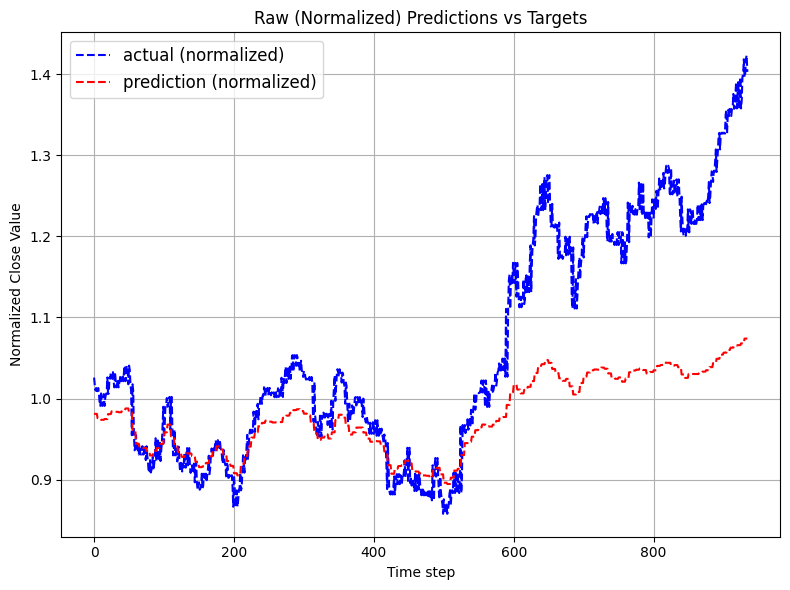

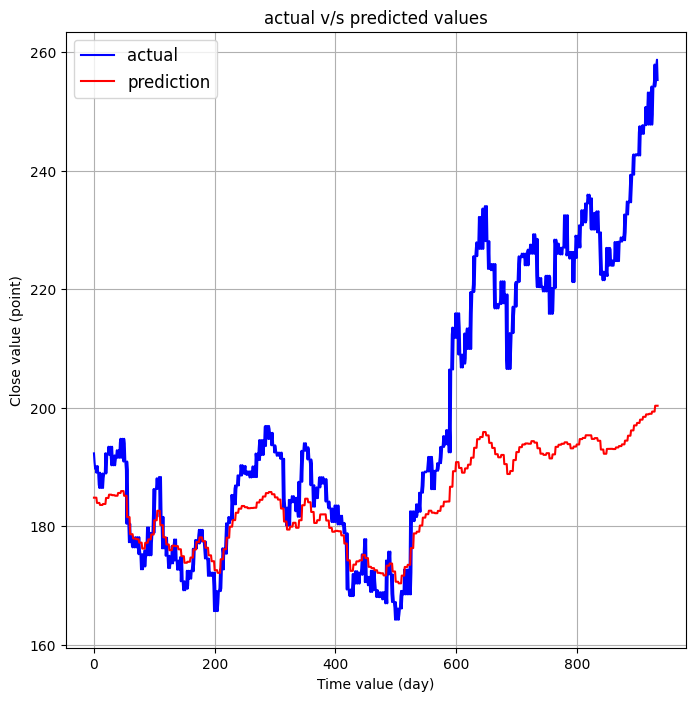

{'val_loss': 0.015927736809287957,
 'val_mae': 0.0897044688463211,
 'val_accuracy': 0.0}

In [13]:
print("here!")
trainer.evaluate(val_loader)